# **Fully-Connected Neural Network**

### *Libraries and functions*

In [1]:
%matplotlib inline
from collections.abc import Sequence
from sklearn import preprocessing
from sklearn import metrics as mt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os



# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

### *Load dataframes from file*

In [2]:
training_df = pd.read_pickle('../data/training_index.pkl')
testing_df = pd.read_pickle('../data/testing_index.pkl')

### *Use dataframe to configure x,y*

In [3]:
training_df['label'] = training_df['label'].astype('category')
testing_df['label'] = testing_df['label'].astype('category')
x_train, y_train = to_xy(training_df, 'label')
x_test, y_test = to_xy(testing_df, 'label')

### *Shape*

In [4]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (82332, 42)
y_train shape: (82332,)
x_test shape: (175341, 42)
y_test shape: (175341,)


### *Model:  relu and adam*

In [5]:
checkpointer = ModelCheckpoint(filepath="best_weights_fcnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(1000, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(125, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

0


Epoch 1/100

2573/2573 - 11s - loss: 0.2748 - val_loss: 0.5812 - 11s/epoch - 4ms/step
Epoch 2/100


c:\Users\cdub6\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2573/2573 - 10s - loss: 0.1893 - val_loss: 0.3731 - 10s/epoch - 4ms/step
Epoch 3/100
2573/2573 - 10s - loss: 0.1624 - val_loss: 0.6106 - 10s/epoch - 4ms/step
Epoch 4/100
2573/2573 - 9s - loss: 0.1457 - val_loss: 0.3743 - 9s/epoch - 4ms/step
Epoch 4: early stopping
1
Epoch 1/100
2573/2573 - 11s - loss: 0.2704 - val_loss: 0.3479 - 11s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 10s - loss: 0.1868 - val_loss: 0.5063 - 10s/epoch - 4ms/step
Epoch 3/100
2573/2573 - 10s - loss: 0.1600 - val_loss: 0.2940 - 10s/epoch - 4ms/step
Epoch 4/100
2573/2573 - 10s - loss: 0.1439 - val_loss: 0.3322 - 10s/epoch - 4ms/step
Epoch 5/100
2573/2573 - 10s - loss: 0.1343 - val_loss: 0.3020 - 10s/epoch - 4ms/step
Epoch 5: early stopping
2
Epoch 1/100
2573/2573 - 10s - loss: 0.2680 - val_loss: 0.3333 - 10s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 9s - loss: 0.1882 - val_loss: 0.3220 - 9s/epoch - 4ms/step
Epoch 3/100
2573/2573 - 9s - loss: 0.1581 - val_loss: 0.3307 - 9s/epoch - 4ms/step
Epoch 4/100
2573/2573 - 10s - l

### *Model:  sigmoid and adam*

In [6]:
checkpointer = ModelCheckpoint(filepath="best_weights_fcnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(1000, input_dim=x_train.shape[1], activation='sigmoid'))
    model.add(Dense(500, activation='sigmoid'))
    model.add(Dense(250, activation='sigmoid'))
    model.add(Dense(125, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

0
Epoch 1/100
2573/2573 - 11s - loss: 0.2789 - val_loss: 0.4203 - 11s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 10s - loss: 0.1941 - val_loss: 0.3798 - 10s/epoch - 4ms/step
Epoch 3/100
2573/2573 - 10s - loss: 0.1708 - val_loss: 0.2658 - 10s/epoch - 4ms/step
Epoch 4/100
2573/2573 - 10s - loss: 0.1508 - val_loss: 0.2784 - 10s/epoch - 4ms/step
Epoch 5/100
2573/2573 - 10s - loss: 0.1382 - val_loss: 0.2172 - 10s/epoch - 4ms/step
Epoch 6/100
2573/2573 - 10s - loss: 0.1289 - val_loss: 0.2149 - 10s/epoch - 4ms/step
Epoch 7/100
2573/2573 - 10s - loss: 0.1257 - val_loss: 0.2173 - 10s/epoch - 4ms/step
Epoch 8/100
2573/2573 - 10s - loss: 0.1231 - val_loss: 0.2475 - 10s/epoch - 4ms/step
Epoch 8: early stopping
1
Epoch 1/100
2573/2573 - 11s - loss: 0.2717 - val_loss: 0.4280 - 11s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 10s - loss: 0.1993 - val_loss: 0.2721 - 10s/epoch - 4ms/step
Epoch 3/100
2573/2573 - 10s - loss: 0.1743 - val_loss: 0.2613 - 10s/epoch - 4ms/step
Epoch 4/100
2573/2573 - 10s - loss: 0

### *Model:  tanh and adam*

In [7]:
checkpointer = ModelCheckpoint(filepath="best_weights_fcnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(1000, input_dim=x_train.shape[1], activation='tanh'))
    model.add(Dense(500, activation='tanh'))
    model.add(Dense(250, activation='tanh'))
    model.add(Dense(125, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

0
Epoch 1/100
2573/2573 - 12s - loss: 0.2847 - val_loss: 0.3593 - 12s/epoch - 5ms/step
Epoch 2/100
2573/2573 - 11s - loss: 0.2237 - val_loss: 0.2587 - 11s/epoch - 4ms/step
Epoch 3/100
2573/2573 - 11s - loss: 0.2056 - val_loss: 0.3762 - 11s/epoch - 4ms/step
Epoch 4/100
2573/2573 - 12s - loss: 0.1909 - val_loss: 0.2943 - 12s/epoch - 5ms/step
Epoch 4: early stopping
1
Epoch 1/100
2573/2573 - 11s - loss: 0.3098 - val_loss: 0.3119 - 11s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 10s - loss: 0.2274 - val_loss: 0.3720 - 10s/epoch - 4ms/step
Epoch 3/100
2573/2573 - 10s - loss: 0.2063 - val_loss: 0.3571 - 10s/epoch - 4ms/step
Epoch 3: early stopping
2
Epoch 1/100
2573/2573 - 11s - loss: 0.2903 - val_loss: 0.3729 - 11s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 10s - loss: 0.2213 - val_loss: 0.2520 - 10s/epoch - 4ms/step
Epoch 3/100
2573/2573 - 11s - loss: 0.2041 - val_loss: 0.3531 - 11s/epoch - 4ms/step
Epoch 4/100
2573/2573 - 11s - loss: 0.1914 - val_loss: 0.4246 - 11s/epoch - 4ms/step
Epoch 4: ea

### *Model:  relu and sgd*

In [8]:
checkpointer = ModelCheckpoint(filepath="best_weights_fcnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(1000, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(250, activation='relu'))
    model.add(Dense(125, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

0
Epoch 1/100
2573/2573 - 9s - loss: 0.6042 - val_loss: 0.5244 - 9s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 9s - loss: 0.5150 - val_loss: 0.3298 - 9s/epoch - 3ms/step
Epoch 3/100
2573/2573 - 9s - loss: 0.4923 - val_loss: 0.4575 - 9s/epoch - 3ms/step
Epoch 4/100
2573/2573 - 9s - loss: 0.4651 - val_loss: 0.3752 - 9s/epoch - 3ms/step
Epoch 4: early stopping
1
Epoch 1/100
2573/2573 - 9s - loss: 0.5995 - val_loss: 0.3949 - 9s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 9s - loss: 0.5089 - val_loss: 0.3869 - 9s/epoch - 3ms/step
Epoch 3/100
2573/2573 - 9s - loss: 0.4833 - val_loss: 0.4796 - 9s/epoch - 3ms/step
Epoch 4/100
2573/2573 - 9s - loss: 0.4727 - val_loss: 0.6328 - 9s/epoch - 3ms/step
Epoch 4: early stopping
2
Epoch 1/100
2573/2573 - 9s - loss: 0.6017 - val_loss: 0.7160 - 9s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 9s - loss: 0.5128 - val_loss: 0.4002 - 9s/epoch - 3ms/step
Epoch 3/100
2573/2573 - 9s - loss: 0.4917 - val_loss: 0.3546 - 9s/epoch - 3ms/step
Epoch 4/100
2573/2573 - 9s - loss

### *Model:  sigmoid and sgd*

In [9]:
checkpointer = ModelCheckpoint(filepath="best_weights_fcnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(1000, input_dim=x_train.shape[1], activation='sigmoid'))
    model.add(Dense(500, activation='sigmoid'))
    model.add(Dense(250, activation='sigmoid'))
    model.add(Dense(125, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

0
Epoch 1/100
2573/2573 - 10s - loss: 0.6888 - val_loss: 0.6698 - 10s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 9s - loss: 0.6881 - val_loss: 0.6461 - 9s/epoch - 3ms/step
Epoch 3/100
2573/2573 - 9s - loss: 0.6871 - val_loss: 0.6510 - 9s/epoch - 3ms/step
Epoch 4/100
2573/2573 - 9s - loss: 0.6850 - val_loss: 0.6557 - 9s/epoch - 3ms/step
Epoch 4: early stopping
1
Epoch 1/100
2573/2573 - 9s - loss: 0.6885 - val_loss: 0.6491 - 9s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 9s - loss: 0.6876 - val_loss: 0.6480 - 9s/epoch - 3ms/step
Epoch 3/100
2573/2573 - 9s - loss: 0.6865 - val_loss: 0.6738 - 9s/epoch - 3ms/step
Epoch 4/100
2573/2573 - 9s - loss: 0.6844 - val_loss: 0.6505 - 9s/epoch - 3ms/step
Epoch 4: early stopping
2
Epoch 1/100
2573/2573 - 9s - loss: 0.6885 - val_loss: 0.6489 - 9s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 9s - loss: 0.6877 - val_loss: 0.6631 - 9s/epoch - 3ms/step
Epoch 3/100
2573/2573 - 9s - loss: 0.6867 - val_loss: 0.6680 - 9s/epoch - 3ms/step
Epoch 3: early stopping
3
Epoch

### *Model:  tanh and sgd*

In [10]:
checkpointer = ModelCheckpoint(filepath="best_weights_fcnn.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    print(i)

    model = Sequential()
    model.add(Dense(1000, input_dim=x_train.shape[1], activation='tanh'))
    model.add(Dense(500, activation='tanh'))
    model.add(Dense(250, activation='tanh'))
    model.add(Dense(125, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=2,epochs=100)

0
Epoch 1/100
2573/2573 - 11s - loss: 0.5796 - val_loss: 0.5305 - 11s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 10s - loss: 0.5091 - val_loss: 0.3901 - 10s/epoch - 4ms/step
Epoch 3/100
2573/2573 - 10s - loss: 0.4741 - val_loss: 0.5896 - 10s/epoch - 4ms/step
Epoch 4/100
2573/2573 - 10s - loss: 0.4703 - val_loss: 0.3741 - 10s/epoch - 4ms/step
Epoch 5/100
2573/2573 - 10s - loss: 0.4615 - val_loss: 1.1360 - 10s/epoch - 4ms/step
Epoch 6/100
2573/2573 - 10s - loss: 0.4303 - val_loss: 0.4442 - 10s/epoch - 4ms/step
Epoch 6: early stopping
1
Epoch 1/100
2573/2573 - 10s - loss: 0.5822 - val_loss: 0.6307 - 10s/epoch - 4ms/step
Epoch 2/100
2573/2573 - 10s - loss: 0.5064 - val_loss: 0.3574 - 10s/epoch - 4ms/step
Epoch 3/100
2573/2573 - 10s - loss: 0.4867 - val_loss: 0.4316 - 10s/epoch - 4ms/step
Epoch 4/100
2573/2573 - 10s - loss: 0.4667 - val_loss: 0.4363 - 10s/epoch - 4ms/step
Epoch 4: early stopping
2
Epoch 1/100
2573/2573 - 10s - loss: 0.5837 - val_loss: 0.4593 - 10s/epoch - 4ms/step
Epoch 2/100

### *Load best model*

In [22]:
model.load_weights('best_weights_fcnn.hdf5')

### *Weights for best model*

In [23]:
model.weights

[<tf.Variable 'dense_145/kernel:0' shape=(42, 1000) dtype=float32, numpy=
 array([[-0.01722332,  0.07573356, -0.04690939, ...,  0.00722678,
         -0.05422064,  0.00253855],
        [-0.03586346,  0.04468323, -0.03554495, ...,  0.00275985,
          0.00355297,  0.02577754],
        [-0.0027531 ,  0.00666644, -0.00519   , ..., -0.06548363,
         -0.18664663, -0.04035763],
        ...,
        [-0.05125153,  0.00072497, -0.00393936, ..., -0.05908339,
         -0.08020897,  0.02713227],
        [ 0.06247975,  0.0140709 , -0.07307205, ...,  0.01017688,
         -0.04438742, -0.07349734],
        [ 0.0146146 , -0.0190134 , -0.06992407, ..., -0.01409002,
          0.01384367,  0.04941825]], dtype=float32)>,
 <tf.Variable 'dense_145/bias:0' shape=(1000,) dtype=float32, numpy=
 array([ 9.23210406e-04, -7.14083028e-04,  8.77946382e-04, -6.32909185e-04,
        -1.71367778e-03,  7.58694601e-04,  3.41443520e-04,  3.77335295e-04,
        -1.04758143e-03,  4.50468069e-04, -7.81494484e-04,  1.

### *Best model summary*

In [24]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_145 (Dense)           (None, 1000)              43000     
                                                                 
 dense_146 (Dense)           (None, 500)               500500    
                                                                 
 dense_147 (Dense)           (None, 250)               125250    
                                                                 
 dense_148 (Dense)           (None, 125)               31375     
                                                                 
 dense_149 (Dense)           (None, 1)                 126       
                                                                 
Total params: 700251 (2.67 MB)
Trainable params: 700251 (2.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### *Recall*

In [25]:
prediction = model.predict(x_test)
threshold = 0.5
binary_prediction = np.where(prediction >= threshold, 1, 0)
recall = mt.recall_score(y_test, binary_prediction, average='weighted')


5480/5480 [==============================] - 6s 1ms/step


### *Accuracy score*

In [31]:
accuracy = mt.accuracy_score(y_test, binary_prediction)

###  *Precision score*

In [27]:
precision = mt.precision_score(y_test, binary_prediction, average='weighted')

### *F1 score*

In [28]:
f1 = mt.f1_score(y_test, binary_prediction, average='weighted')

### *Classification Report*

In [29]:
print(mt.classification_report(y_test, binary_prediction))

              precision    recall  f1-score   support

         0.0       0.87      0.80      0.83     56000
         1.0       0.91      0.94      0.93    119341

    accuracy                           0.90    175341
   macro avg       0.89      0.87      0.88    175341
weighted avg       0.90      0.90      0.90    175341



### *Confusion matrix*

[[ 44914  11086]
 [  6860 112481]]
Plotting confusion matrix


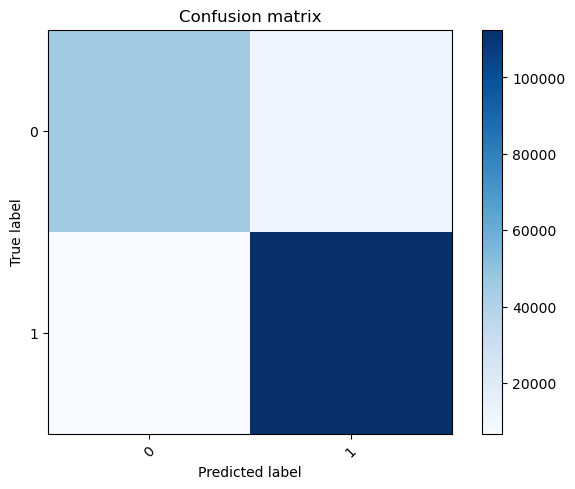

In [18]:
diagnosis = encode_text_index(training_df, 'label')

cm = confusion_matrix(y_test, binary_prediction)
print(cm)

print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cm, diagnosis)
plt.show()

### *ROC Curve*

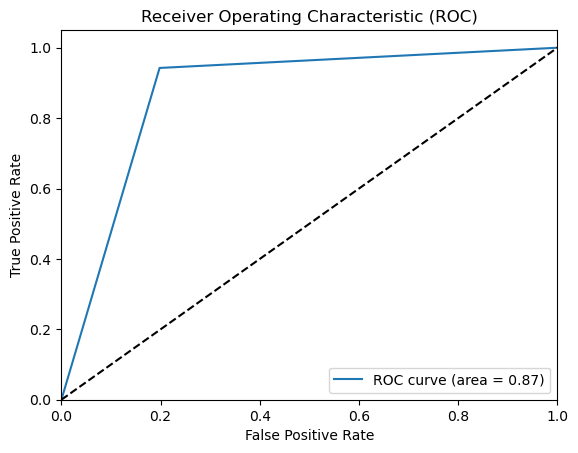

In [19]:
plot_roc(binary_prediction, y_test)